## Лабораторная работа 2.
### Обесцвечивание и бинаризация растровых изображений

ФИО: Монастырный Максим Александрович

Группа: Б24-501 

In [1]:
from pathlib import Path

import numpy as np
from PIL import Image

In [2]:
data_dir = Path("../data")

Исходное изображение

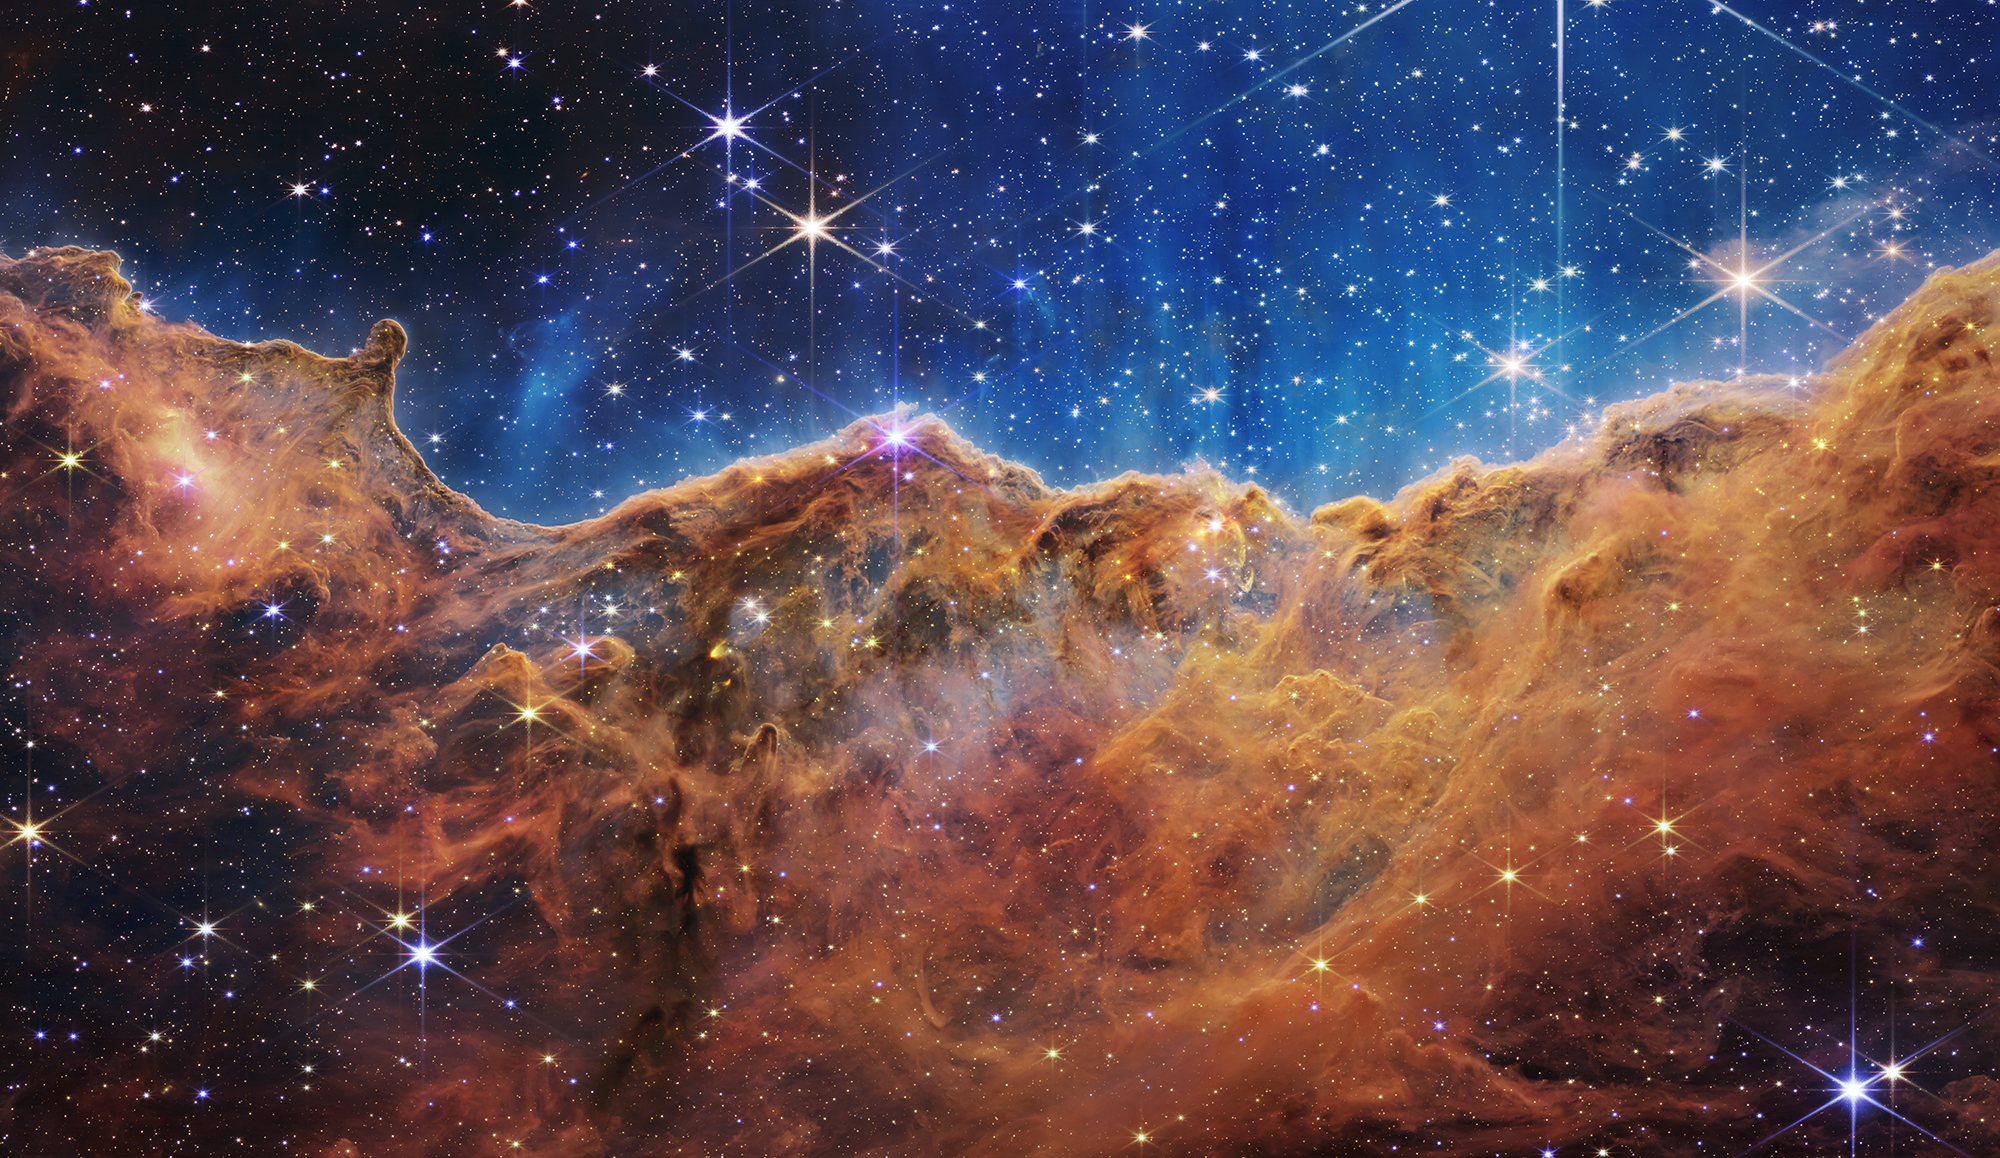

In [3]:
image_path = data_dir / "test_image.png"
raw_image = Image.open(image_path)
source_image = np.array(raw_image)
raw_image

1. Приведение полноцветного изображения к полутоновому. Новое изображение
создаётся в режиме полутона (1 яркостный канал, формат bmp), где яркость
каждого пикселя вычисляется (взвешенным) усреднением каналов исходного
полноцветного изображения.

In [4]:
def to_grayscale(input_image: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
    """Converts a color image to grayscale using optional channel weights.

    Args:
        input_image: A NumPy array representing the color image.
            Expected shape is (height, width, channels).
        weights: Optional array of weights for each channel. Must be 1D and have
            length equal to the number of channels in `input_image`.
            If not provided, uniform weights are used.

    Returns:
        The grayscale image with dtype uint8.
    """
    if input_image.ndim < 3 or input_image.shape[-1] < 1:
        raise ValueError(
            f"Input image must be at least 3D with shape (H, W, C); got {input_image.shape}."
        )
    if not weights:
        weights = np.ones(input_image.shape[-1])

    weights = np.asarray(weights)
    weights = weights.flatten()

    if weights.shape != (input_image.shape[-1],):
        raise ValueError(
            f"Weights length ({weights.shape[0]}) does not match number of "
            f"image channels ({input_image.shape[-1]}). Expected shape: "
            f"{(input_image.shape[-1],)}."
        )

    return np.average(input_image, axis=-1, weights=weights).astype(np.uint8)

In [5]:
grayscale_image = Image.fromarray(
    to_grayscale(
        source_image,
        weights=[0.2126, 0.7152, 0.0722],  # sRGB
    )
)

In [6]:
grayscale_image.save(data_dir / "grayscale_image.bmp")

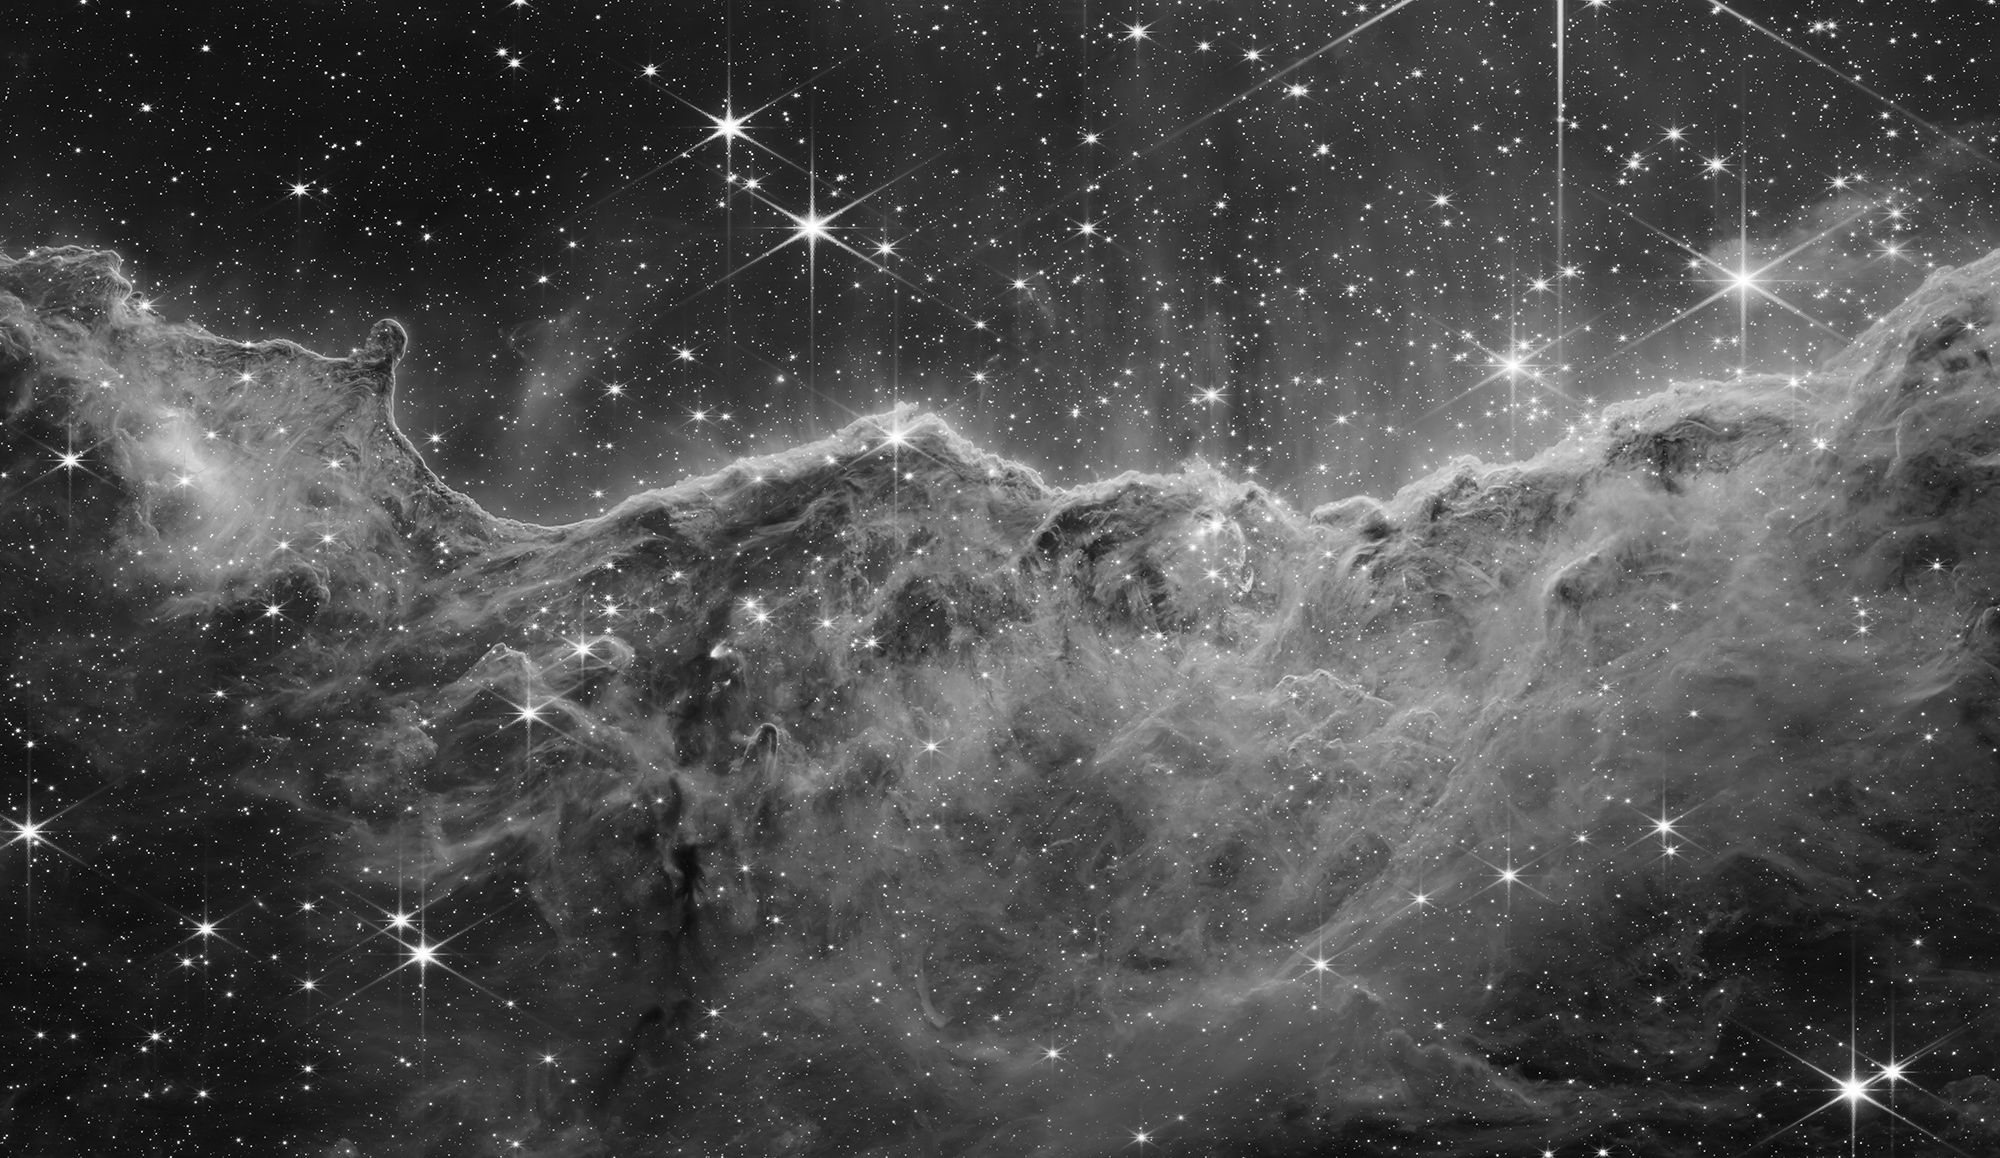

In [7]:
Image.open(data_dir / "grayscale_image.bmp")

2. Приведение полутонового изображения к монохромному методом пороговой
обработки. Демонстрируется на нескольких изображениях, например: контурная
карта, рентгеновский снимок, скриншот из мультфильма, фотография, отпечаток
пальца, неравномерно засвеченная страница текста.

Вариант 11: 

Адаптивная бинаризация Феня и Тана (окно 3х3)

In [ ]:
def binarization(
    input_image: np.ndarray,
    kernel_size: int = 3,
    alpha_1: float = 0.15,
    gamma: float = 2.0,
    k1: float = 0.2,
    k2: float = 0.03,
    padding_mode: str = "symmetric",
) -> np.ndarray:
    """Performs adaptive image binarization.

    Args:
        input_image (np.ndarray): 2D grayscale input image.
        kernel_size (int, optional): Size of the local window used to compute
            local statistics. Must be a positive odd integer. Defaults to 3.
        alpha_1 (float, optional): Weight factor controlling influence of the
            local minimum. Must be positive. Defaults to 0.1.
        gamma (float, optional): Exponent for contrast adjustment. Must be positive.
            Defaults to 2.0.
        k1 (float, optional): Weight factor for the local contrast term.
            Must be positive. Defaults to 0.15.
        k2 (float, optional): Weight factor for the global minimum term.
            Must be positive. Defaults to 0.01.
        padding_mode (str, optional): Padding mode for the image borders.
            Follows NumPy's `np.pad` modes (e.g., "symmetric", "reflect", "edge").
            Defaults to "symmetric".

    Returns:
        np.ndarray: Binary image of the same shape as `input_image`, with pixel values
        of 0 (background) or 255 (foreground).
    """

    if kernel_size < 1 or kernel_size % 2 == 0:
        raise ValueError("kernel_size must be a positive odd integer")

    if any(param <= 0 for param in [alpha_1, gamma, k1, k2]):
        raise ValueError("alpha_1, gamma, k1, and k2 must be positive")

    img = np.asarray(input_image, dtype=np.float32)
    if img.ndim != 2:
        raise ValueError("input_image must be a 2D (grayscale) array")

    global_min = float(img.min())

    pad = kernel_size // 2
    img_padded = np.pad(img, pad_width=pad, mode=padding_mode)
    
    windows = np.lib.stride_tricks.sliding_window_view(
        img_padded, (kernel_size, kernel_size)
    )

    min_matrix = np.min(windows, axis=(-2, -1))
    std_matrix = np.std(windows, axis=(-2, -1), ddof=0)

    eps = 1e-6
    r_coeff = float(std_matrix.max()) if float(std_matrix.max()) > eps else eps
    std_ratio = std_matrix / r_coeff
    std_ratio_power = np.power(std_ratio, gamma)

    threshold = (
        (1.0 - alpha_1) * min_matrix
        + k1 * std_ratio_power * std_ratio * (min_matrix - global_min)
        + k2 * std_ratio_power * global_min
    )

    output_image = np.where(threshold >= r_coeff, 255, 0).astype(np.uint8)
    return output_image

In [9]:
binarized_image = Image.fromarray(binarization(grayscale_image))

In [10]:
binarized_image.save(data_dir / "binarized_image.bmp")

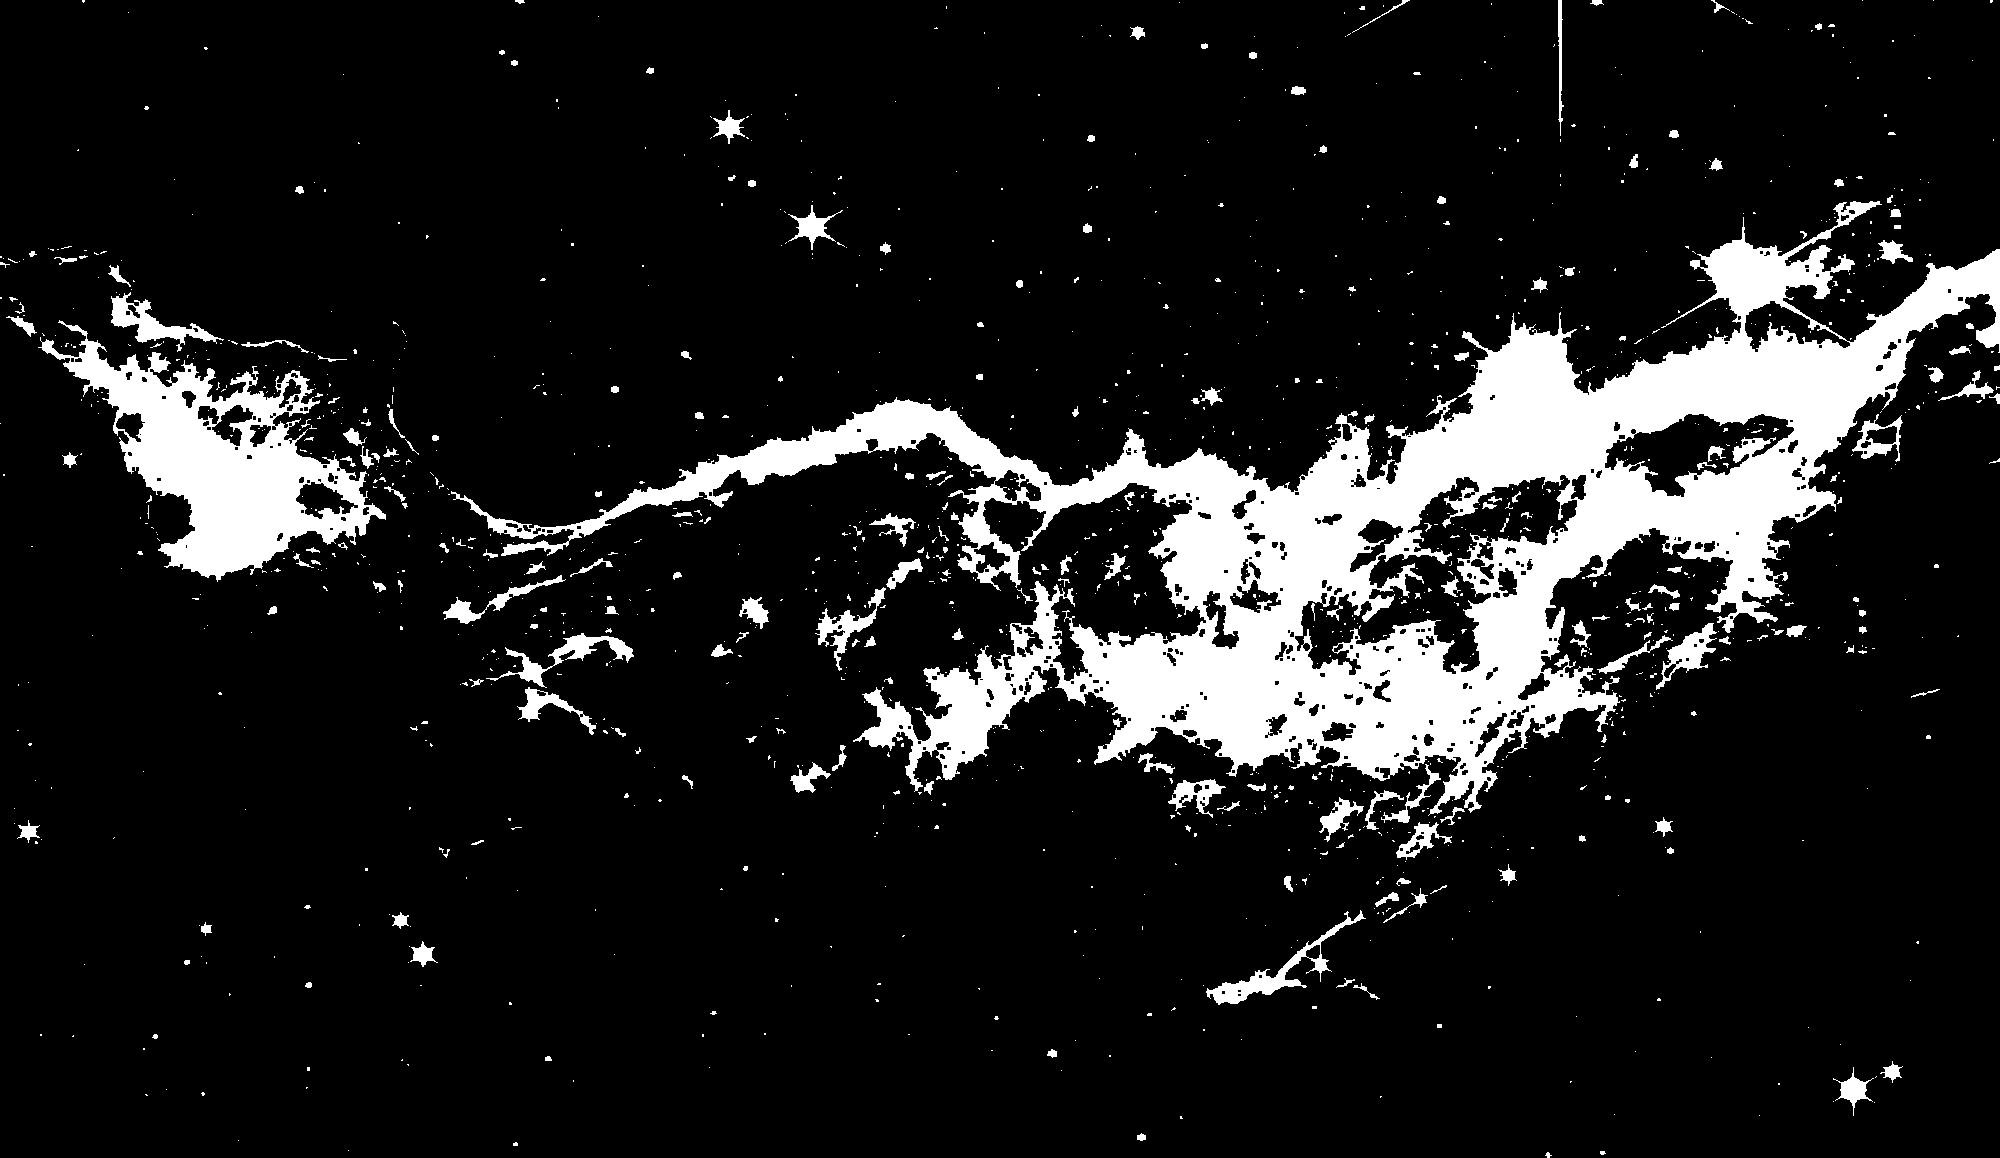

In [11]:
Image.open(data_dir / "binarized_image.bmp")